# Plot and visualize peaks

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/roger/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


In [3]:
config = dict(
    python_path='/home/roger/miniforge3/envs/ms-main/bin/python',
    gen_ckpt='/home/roger/ms-models/iceberg_results_20241111/dag_nist20/split_1_rnd1/version_0/best.ckpt',
    inten_ckpt='/home/roger/ms-models/iceberg_results_20241111/dag_inten_nist20/split_1_rnd1/version_1/best.ckpt',
    cuda_devices=0,
    batch_size=8,
    num_workers=6,
    sparse_k=100,
    max_nodes=100,
    threshold=0.0,
    binned_out=False,
    ppm=20,
    num_bins=15000,
    dist_func='entropy'
)
common.plot_utils.set_style()

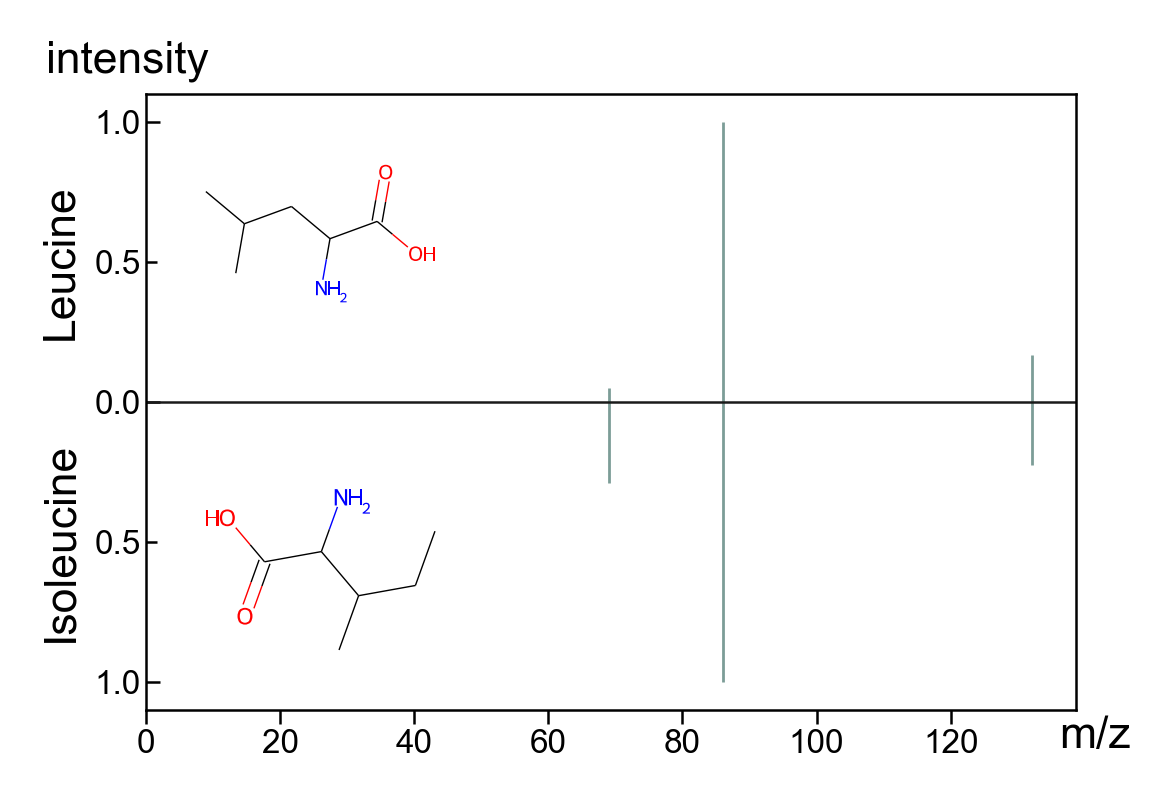

In [38]:
leu_spec = load_real_spec('nist_1250935', 'nist')
isoleu_spec = load_real_spec('nist_1188546', 'nist')

plt.figure(figsize=(3, 2), dpi=400)
ax = plt.gca()
common.plot_compare_ms(leu_spec['13'], isoleu_spec['13'], 'Leucine', 'Isoleucine', ax=ax, ppm=50)
# plt.savefig('leu-ile.pdf')
common.plot_mol_as_vector(Chem.MolFromSmiles('CC(C)CC(N)C(=O)O'), ax=ax, offset=(130/5, 0.6), zoom=0.003)
common.plot_mol_as_vector(Chem.MolFromSmiles('CCC(C)C(N)C(=O)O'), ax=ax, offset=(130/5, -0.6), zoom=0.003)

In [5]:
# Only show peak predictions
def visual_preds(pred_smi, colli_energies=[10, 20, 30, 40, 50], nce=False, merge_ces=False, explain_npeaks=0, name="", **kwargs):
    _config = copy.deepcopy(config)
    _config['nce'] = nce  # use nce for collision energy
    _config['merge_spec'] = merge_ces # merge spec for visualization
    for k, v in kwargs.items():
        _config[k] = v

    # Get candidates
    smiles = [pred_smi]

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, colli_energies, **_config)

    # Visualize and explain peaks
    from matplotlib.backends.backend_pdf import PdfPages
    all_figs = []
    fig, axes = plt.subplots(len(colli_energies), 1, figsize=(3, 1. * len(colli_energies)), dpi=500)
    fig = explain_peaks(result_path, None, pmz, pred_smi, num_peaks=explain_npeaks, axes=axes, **_config)
    all_figs += fig
    p = PdfPages(f'{name}.pdf')
    for fig in all_figs:
        fig.savefig(p, format='pdf')
    p.close()

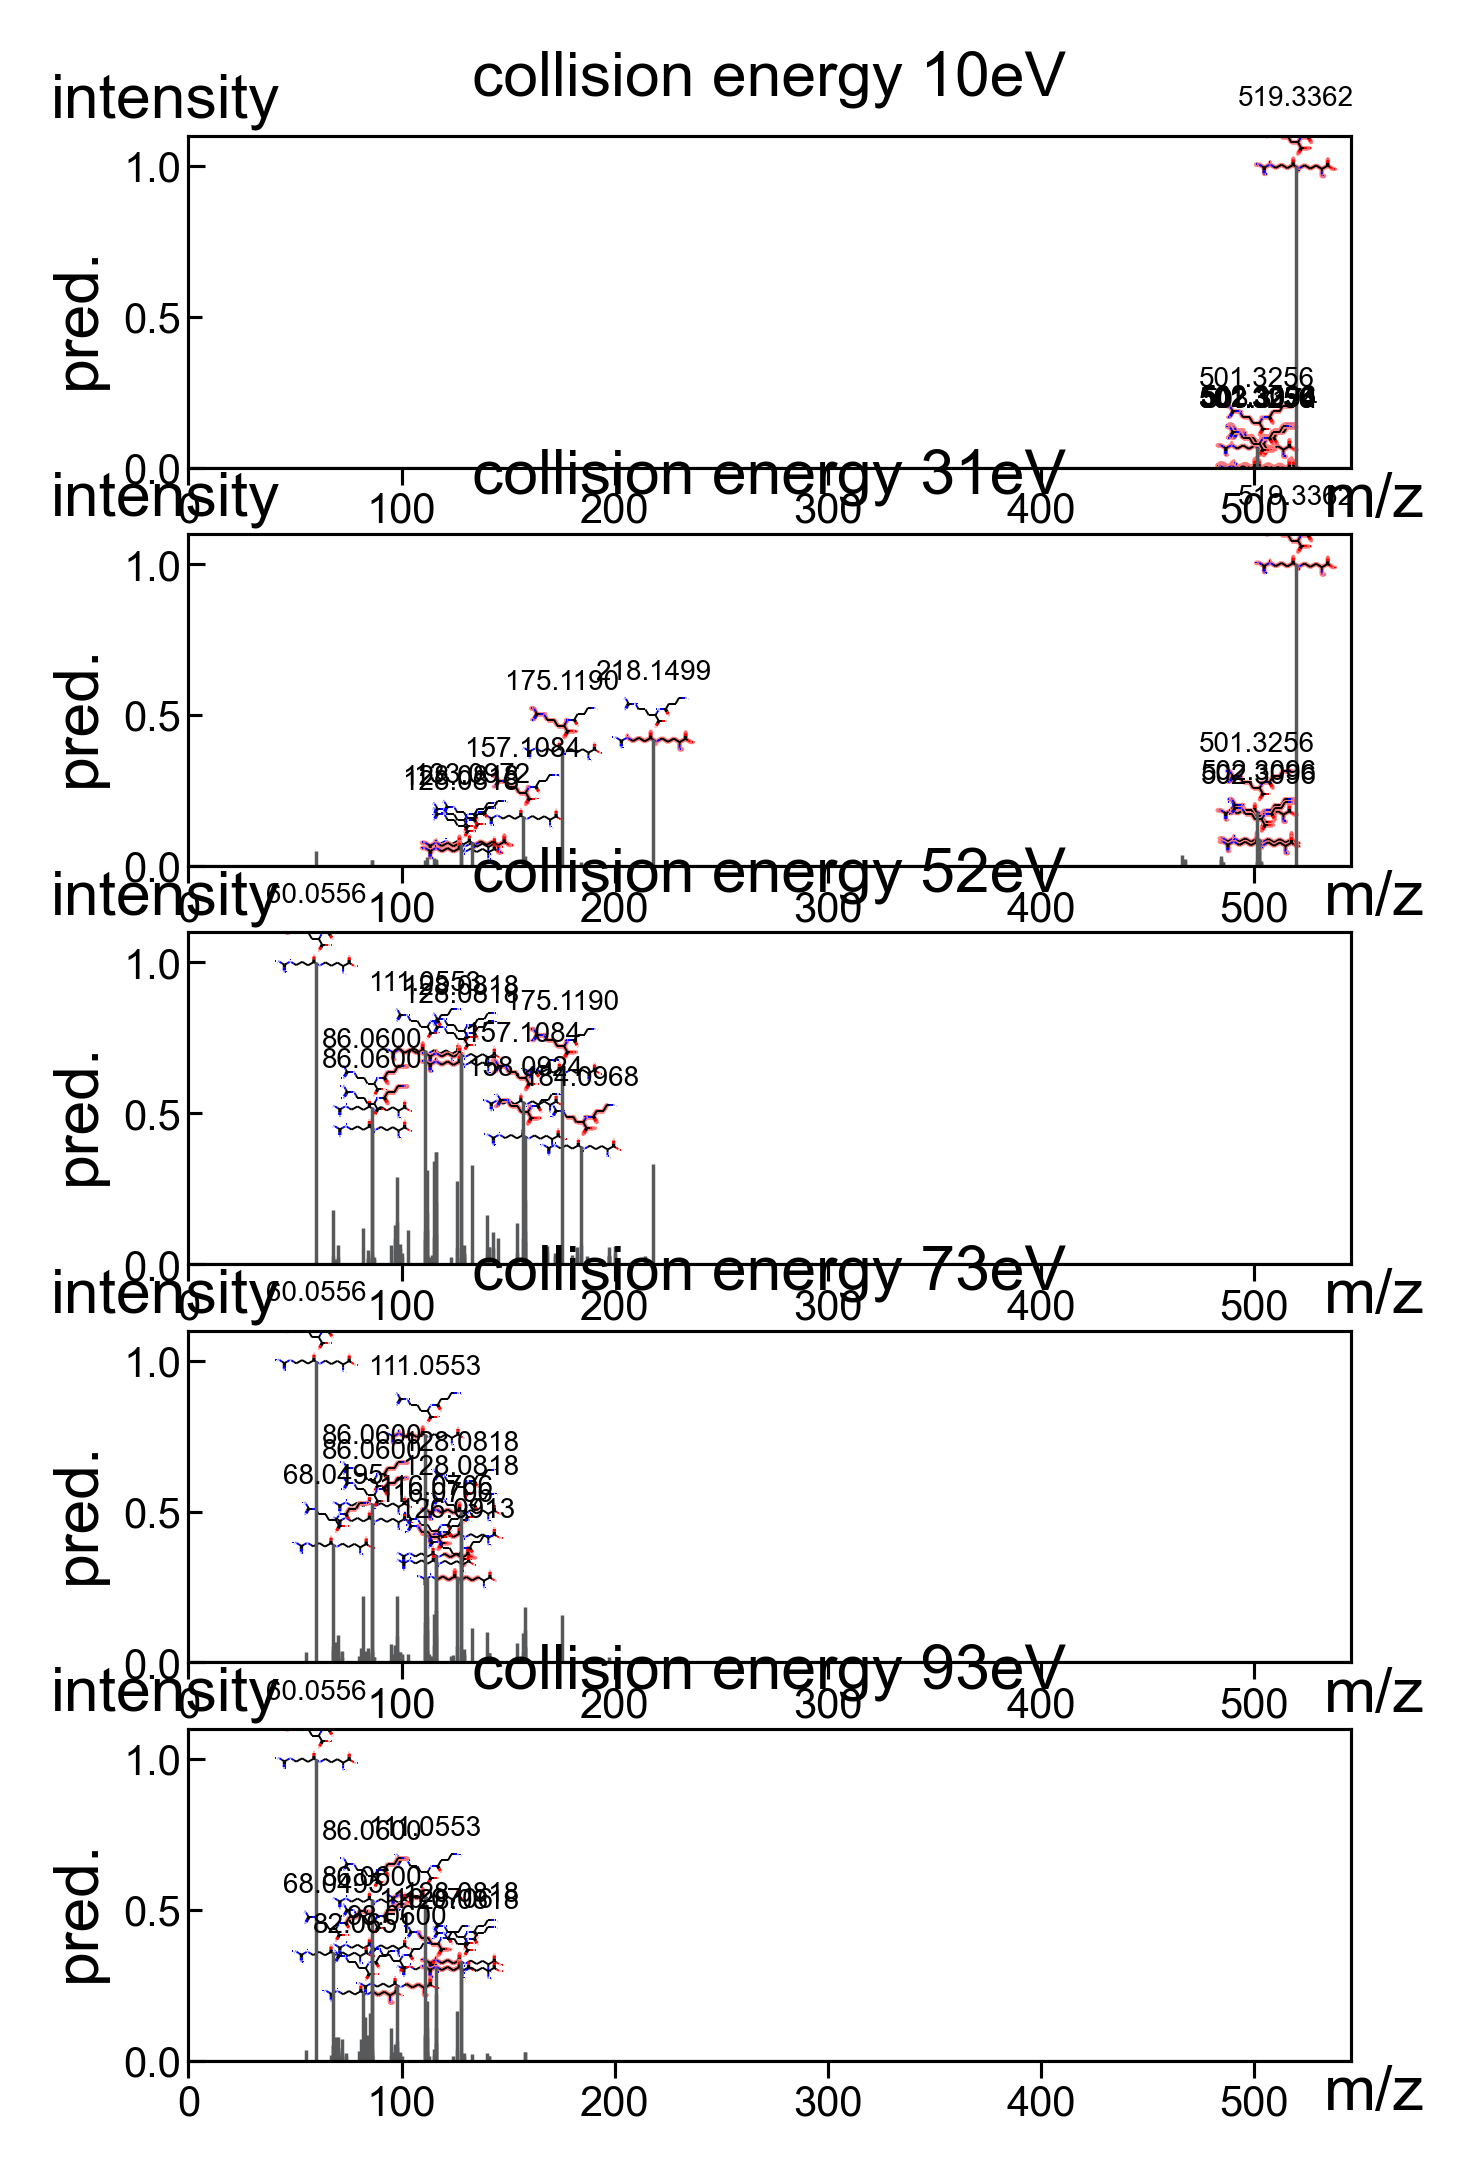

In [20]:
visual_preds(r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N.O=C(O)C(N)CCCNC(CCC/N=C(N)\N)=O', np.arange(10, 100, 20), nce=True, explain_npeaks=10, name='gaba-arg')

In [17]:
# Show peak predictions + experiment spectrum matching
def visual_preds_compare(pred_smi, exp_spec_path, colli_energies=[10, 20, 30, 40, 50], nce=False, merge_ces=False, explain_npeaks=0, name="", real_spec_type='ms', **kwargs):
    _config = copy.deepcopy(config)
    _config['nce'] = nce  # use nce for collision energy
    _config['merge_spec'] = merge_ces # merge spec for visualization
    for k, v in kwargs.items():
        _config[k] = v

    # Get candidates
    smiles = [pred_smi]

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, colli_energies, **_config)

    # Visualize and explain peaks
    from matplotlib.backends.backend_pdf import PdfPages
    all_figs = []
    fig, axes = plt.subplots(len(colli_energies), 1, figsize=(3, 2. * len(colli_energies)), dpi=500)
    fig = explain_peaks(result_path, exp_spec_path, pmz, pred_smi, num_peaks=explain_npeaks, axes=axes, pmz=pmz, real_spec_type=real_spec_type, **_config)
    all_figs += fig
    p = PdfPages(f'{name}.pdf')
    for fig in all_figs:
        fig.savefig(p, format='pdf')
    p.close()

CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/d29ac43d26bfd09fbe7e98357ebba185/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20241111/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20241111/dag_inten_nist20/split_1_rnd1/version_1/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/d29ac43d26bfd09fbe7e98357ebba185 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-12-17 17:18:06,866 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/d29ac43d26bfd09fbe7e98357ebba185/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20241111/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20241111/dag_inten_nist20/split_1_rnd1/version_1/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/d29ac43d26bfd09fbe7e98357ebba185
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-12-17 17:18:07,332 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20241111/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20241111/dag_inten_nist20/split_1_rnd1/version_1/best.ckpt
2024-12-17 17:18:

  0%|          | 0/1 [00:00<?, ?it/s]

2024-12-17 17:18:13,699 INFO: There are 5 entries to process


100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


2024-12-17 17:18:16,492 INFO: Program finished in: 9.639291763305664 seconds


ValueError: Precursor mass is different from loaded spectrum metadata! Got m/z=519.336156, loaded from spec=260.17172

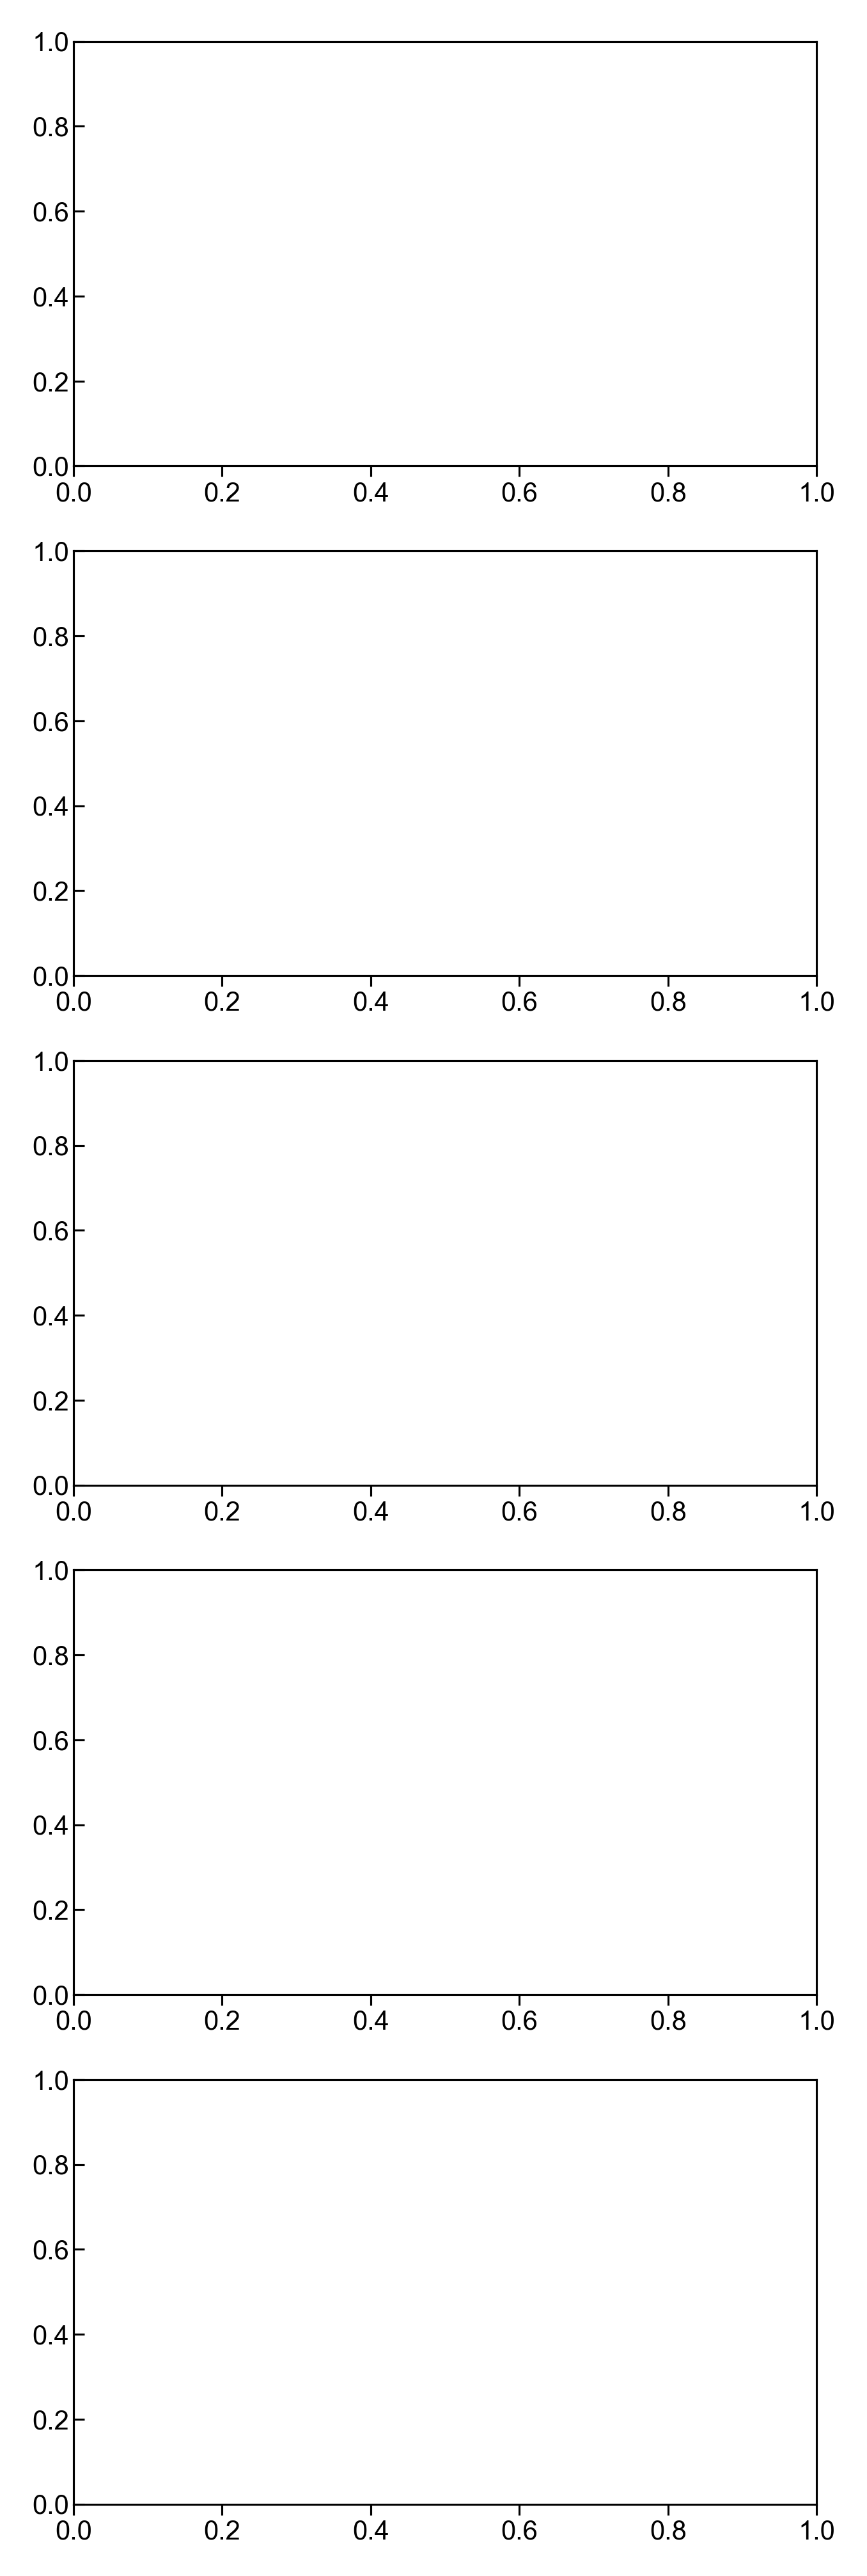

In [18]:
visual_preds_compare(r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N',
                     f'/home/roger/ms_collaborators/broad-Julian/spec_files/mxp4308.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=10, name='gaba-arg')

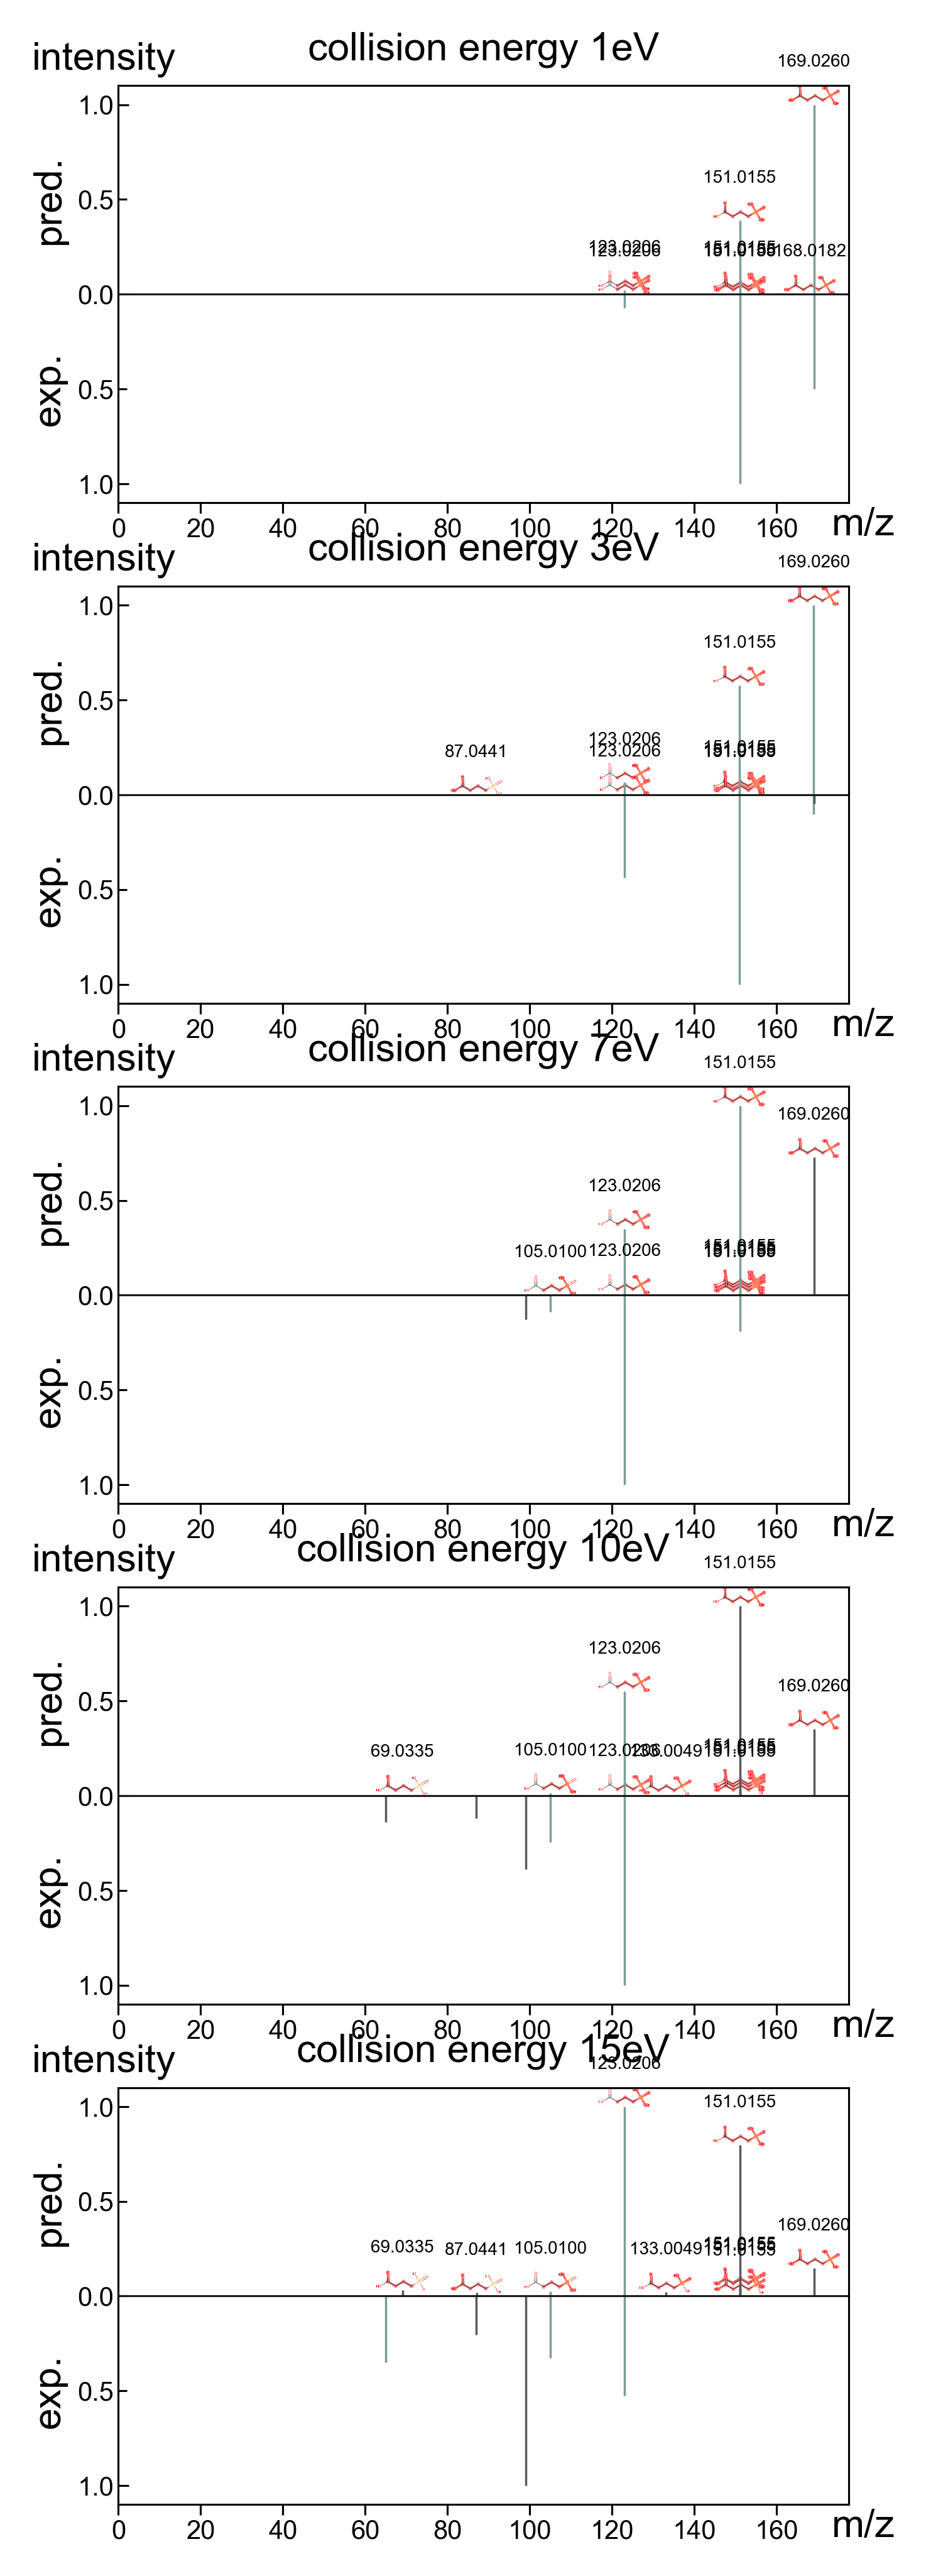

In [47]:
visual_preds_compare(r'C(CC(=O)O)CP(=O)(O)O',
                     f'nist_1144025',
                     [2, 10, 20, 30, 45], nce=True, explain_npeaks=10, real_spec_type='nist', name='phospho')